
# Семинар 8 - Алгоритмы анализа стереопар изображений

***

Полезные материалы:

- [First Principles of Computer Vision - Camera Calibration | Uncalibrated Stereo](https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=iXEBEehuQr-IgIVC) - плейлист с серией лекций по калибровке камеры и стереозрению
- [Simple Stereo | Camera Calibration](https://youtu.be/hUVyDabn1Mg?si=HmalQZKI9ytoyxPn) - лекция из плейлиста выше, в которой доступно раскрывается тема данного семинара

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. **3D реконструкция с нескольких ракурсов**: знаем параметры калибровки каждой из камер, необходимо найти положение 3D объекта в мировых координатах.

2. **Оценка на основе движения (Structure From Motion)**: не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

Первая задача проще в своей постановке, рассмотрим ее.

## Моно/Стерео зрение

_Источник изображений: https://github.com/polygon-software/python-visual-odometry_

![1_projection_and_stereo](data/1_projection_and_stereo.png)

**Идея:** можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![3_stereo_cases](data/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![4_stereo_vision_simple](data/4_stereo_vision_simple.png)

## Вопрос 1 

Зная $f$ (фокальное расстояние камер), $b$ (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$.

**Ответ:** $Z_p = = \frac{f * b}{u_l = u_r}$

## Расчет диспаратности с помощью OpenCV

In [2]:
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O data/tsukuba_l.png
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O data/tsukuba_r.png

--2024-04-19 20:41:06--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85192 (83K) [image/png]
Saving to: ‘data/tsukuba_l.png’

data/tsukuba_l.png  100%[===================>]  83.20K  --.-KB/s    in 0.05s   

2024-04-19 20:41:06 (1.56 MB/s) - ‘data/tsukuba_l.png’ saved [85192/85192]

--2024-04-19 20:41:06--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, 

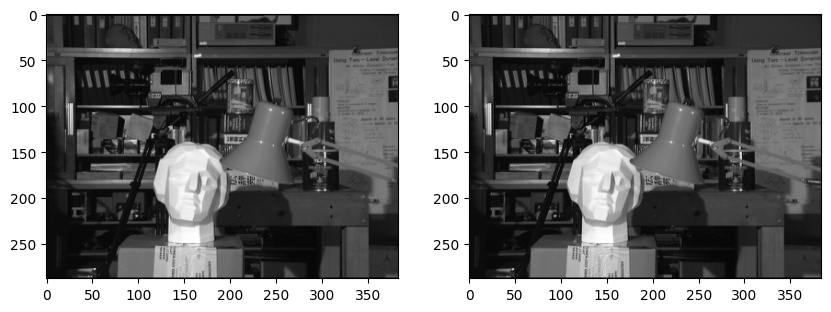

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL, cmap="gray")
ax[1].imshow(imgR, cmap="gray")

### cv2.StereoBM_create

https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

Чем меньше `blockSize` - тем детальнее карта диспаратности, однако и количество шума растет.

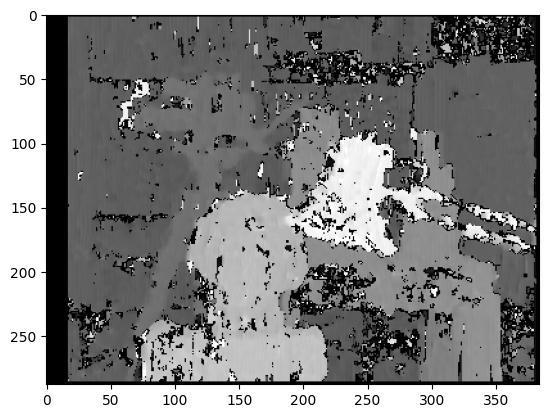

In [4]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=5,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

При слишком больших значениях `blockSize` шум отсутствует, однако детализация крайне низка:

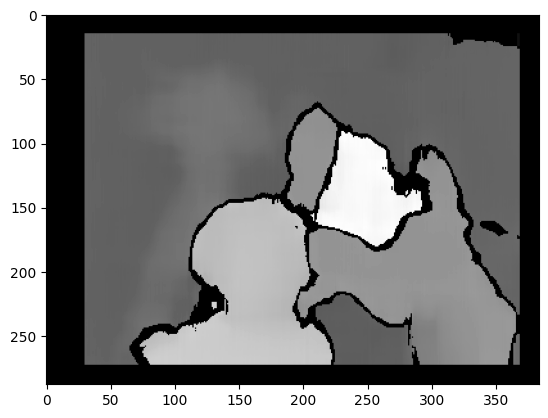

In [5]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=31,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

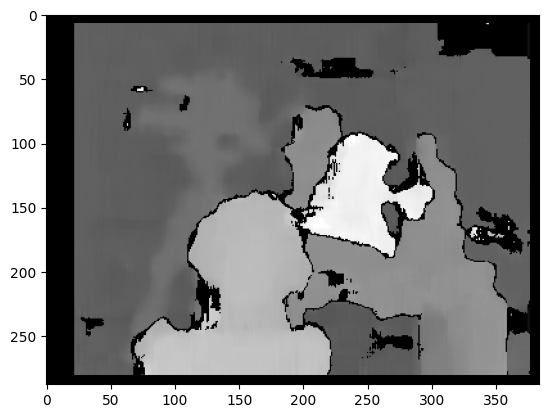

In [6]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=15,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

## Задание 1 - реализация алгоритма расчета диспаратности

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

![alg](data/alg.png)

**Заполните пропуски в коде**

In [13]:
def compare_blocks(
    block_left: np.array,
    block_right: np.array,
) -> float:
    '''
    Takes blocks from left/right image
    and return similarity metric (for example, sum of absolute differences)
    '''

    assert block_left.shape == block_right.shape, 'Blocks are not equal'
    metric = np.sum(np.abs(block_left - block_right))
    return metric


def get_disparity(
    imgL: np.array,  # (H, W) Grayscale
    imgR: np.array,  # (H, W) Grayscale
    numDisparities: int,  # the same in opencv
    blockSize: int,  # the same in opencv
) -> np.array:

    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)  # (H, W)

    for i in range(H):
        for j in range(W):

            # define base block to compare
            # using blockSize and i, j

            block_left = imgL[max(0, i - blockSize // 2):min(H, i + blockSize // 2 + 1),
                             max(0, j - blockSize // 2):min(W, j + blockSize // 2 + 1)]
            metrics = []

            for k in range(1, numDisparities):

                # define secondary block to compare
                # using blockSize and i, j
                block_right = imgR[max(0, i - blockSize // 2):min(H, i + blockSize // 2 + 1),
                                  max(0, j - k - blockSize // 2):min(W, j - k + blockSize // 2 + 1)]

                # metrics.append(
                #     compare_blocks(
                #       block_left,
                #       block_right
                #     )
                # )
                
                if block_left.shape == block_right.shape:
                        metrics.append(compare_blocks(block_left, block_right))
                else:
                    metrics.append(float('inf'))

            best_index = np.argmin(metrics)

            # convert index to disparity
            # and fill it in disparity_map
            if metrics[best_index] != float('inf'):
                disparity_map[i, j] = best_index
            else:
                disparity_map[i, j] = 0

    return disparity_map



## Вопрос 2

Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.)

**Ответ:** Приведенный базовый алгоритм расчета диспаратности не обеспечивает точное заполнение всех пикселей глубины. Для улучшения можно:

Пороговая оценка. При превышении минимального значения SAD установить значение диспаритета по умолчанию (например, 0) для областей с низким уровнем доверия к совпадению.
Постобработка. Применить медианную фильтрацию для удаления шума и сглаживания карты диспаратности с сохранением краев.
Использовать другие критерии сопоставления, например, SSD или нормализованную кросс-корреляцию для улучшения работы алгоритма при определенных условиях.

## Задание 2

Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

In [16]:
!pip install -U scikit-learn scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 4.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 3.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.3
    Uninstalling matplotlib-3.8.3:
      Successfully uninstalled matplotlib-3.8.3


In [17]:
import cv2
from sklearn.metrics import mean_squared_error

# Загруз изображения
imgL = cv2.imread('data/tsukuba_l.png', 0)
imgR = cv2.imread('data/tsukuba_r.png', 0)

# Получение карты диспаратности с помощью вашего алгоритма
disparity_map_custom = get_disparity(imgL, imgR, numDisparities=16, blockSize=15)

# Создание объекта StereoBM и вычисление карты диспаратности с помощью OpenCV
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_map_opencv = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Подготовка карт диспаратности для сравнения (нормализация к одинаковому масштабу)
disparity_map_opencv[disparity_map_opencv < 0] = 0

# Сравнение карт с помощью MSE
mse = mean_squared_error(disparity_map_custom, disparity_map_opencv)

# Вывод результатов сравнения
print(f"Среднеквадратическая ошибка (MSE) между картами: {mse}")

Среднеквадратическая ошибка (MSE) между картами: 27.830339431762695


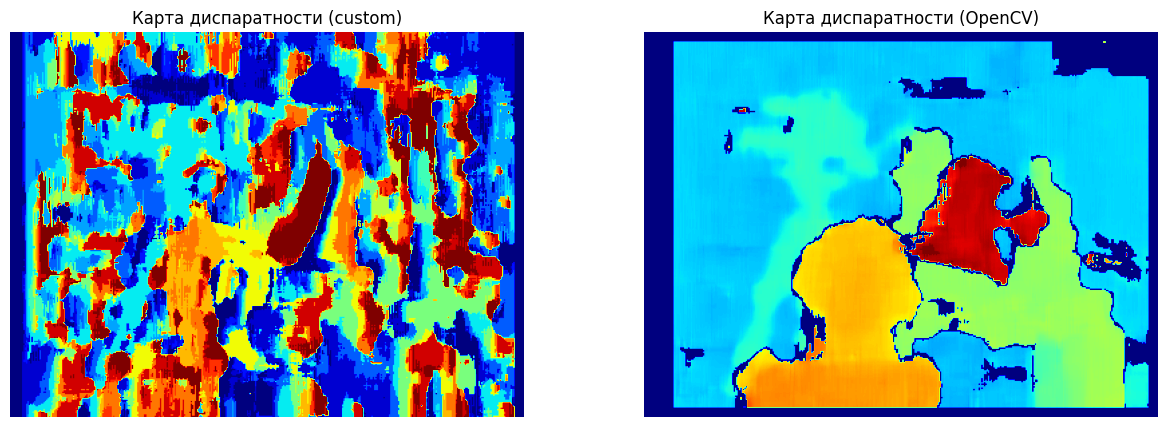

In [22]:
import matplotlib.pyplot as plt

disparity_map_custom_vis = cv2.normalize(disparity_map_custom, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_map_opencv_vis = cv2.normalize(disparity_map_opencv, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(disparity_map_custom_vis, cmap='jet')
axes[0].set_title('Карта диспаратности (custom)')
axes[0].axis('off')

axes[1].imshow(disparity_map_opencv_vis, cmap='jet')
axes[1].set_title('Карта диспаратности (OpenCV)')
axes[1].axis('off')

plt.show()


## Вопрос 3

Как еще с помощью пройденных классических алгоритмов можно построить карту диспаратности? Приведите краткое описание придуманного/существующего алгоритма.

**Ответ:**  Для построения карты диспаратности помимо использования классических алгоритмов стереозрения можно воспользоваться алгоритмом семейства блочных матчеров. Один из таких алгоритмов - алгоритм Semi-Global Matching (SGM).

Вот краткое описание алгоритма SGM:

1. **Определение стоимости соответствия**: Прежде всего, определяется стоимость соответствия между каждым пикселем левого изображения и его потенциальными соответствиями в правом изображении.

2. **Построение энергетической функции**: Далее строится энергетическая функция, которая учитывает не только стоимость соответствия для каждого пикселя, но и сглаживающие штрафы за различия соседних пикселей.

3. **Оптимизация энергетической функции**: Процесс оптимизации энергетической функции производится с использованием методов динамического программирования, что позволяет найти оптимальную карту диспаратности.

4. **Получение карты диспаратности**: В результате работы алгоритма получается карта диспаратности, на которой каждому пикселю в левом изображении соответствует его сдвиг или диспаратность в правом изображении.

Алгоритм Semi-Global Matching широко используется в компьютерном зрении и робототехнике для операций стереозрения и восстановления трехмерной информации.  